## Import libraries

In [1]:
import ee
import geemap
import os
import pandas as pd
import csv

## Create an interactive map

In [2]:
# Map = geemap.Map(center=[40, -100], zoom=4)
Map = geemap.Map()
# Map

## Add Earth Engine Python script

In [8]:
#Convert 'nilai' property from string to number.
def func_vjt(feature):
    num = ee.Number.parse(feature.get('nilai'))
    return feature.set('nilai', num)

# Add Earth Engine dataset
# image = ee.Image("USGS/SRTMGL1_003")
polygons = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/box_karawang');

# Sample in 2020
sample1 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_01').map(func_vjt)
# Change .../2020_01 for get data in another month

# Get time for prediction
start_date = ee.Date('2020-01-01')
finish_date = ee.Date('2020-01-30')
orbit = 'ASCENDING'
# januari: 1-31
# feb: 1-29
# maret: 1-31
# april: 1-30
# mei: 1-31
# juni: 1-30
# juli: 1-31
# agustus: 1-31
# september: 1-30
# oktober: 1-31
# november: 1-30
# des: 1-31

def func_mgd(image):
    return image.clip(polygons)

# Get the VV collection.
collectionS1 = ee.ImageCollection('COPERNICUS/S1_GRD').map(func_mgd) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filterDate(start_date, finish_date) \
    .filterBounds(polygons)\

collectionVV = collectionS1.select('VV')
collectionVH = collectionS1.select('VH')

VV = ee.Image(collectionVV.median())
VH = ee.Image(collectionVH.median())
VVVH = VV.divide(VH)

bandsall = ['0_VH', '1_VV', '2_VV']
bandsvh = ['0_VH']
bandsvv = ['1_VV']
bandsvvvh = ['2_VV']

mosaic = collectionVV.mosaic()

fincol = ee.ImageCollection([VH, VV, VVVH])
finLayer = fincol.toBands()

# Training seluruh bulan
label = 'nilai'
trainingall = finLayer.select(bandsall).sampleRegions(collection= sample1, properties= [label], scale = 12);
trainedtb = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)
classifiedtb = finLayer.select(bandsall).classify(trainedtb)
Map.centerObject(polygons, 11)
Map.addLayer(sample1, {}, 'Sampel', True)

# Declare warna-warna di map. index array sesuai nomor zone
palette = ['34B3F1', '06FF00', '224B0C', 'FFE400', '541212', 'FF449F', 'EB1D36', 'CA955C']
# badan air --> blue: 34B3F1
# vegetasi awal --> green: 06FF00
# vegetasi akhir --> dark green: 224B0C
# generative --> yellow: FFE400
# panen dan pl --> dark red: 541212 
# sawah bukan padi --> magenta: FF449F
# lain-lain --> red: EB1D36
# permukiman --> brown: CA955C

#Deklarasi Map
Map.addLayer(classifiedtb, {'min': 0, 'max': 8, 'palette': palette}, 'Class Grad Tree Boost')

zonestb = classifiedtb.gt(0).add(classifiedtb.gt(1)) \
.add(classifiedtb.gt(2)) \
.add(classifiedtb.gt(3)) \
.add(classifiedtb.gt(4)) \
.add(classifiedtb.gt(5)) \
.add(classifiedtb.gt(6)) \
.add(classifiedtb.gt(7))

vectorstb = zonestb.addBands(classifiedtb).reduceToVectors(geometry= polygons, crs=classifiedtb.projection(), scale= 100,geometryType= 'polygon', eightConnected= False, labelProperty= 'zone', reducer= ee.Reducer.mean())

## Download

In [9]:
# Add layer map
polygons1 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/kab_karawang')
new1 = classifiedtb.clip(polygons1)
Map.addLayer(new1, {'min': 1, 'max': 8, 'palette': palette}, 'GB - Crop')
Map.addLayer(new1, {'min': 1, 'max': 5, 'palette': palette}, 'GB - Sawah aja')
Map.addLayer(polygons1, {}, 'GB - Area Karawang')

In [10]:
# Show map
Map

Map(center=[-6.2602313619008285, 107.37305787739075], controls=(WidgetControl(options=['position', 'transparen…

In [11]:
new2 = ee.Image.pixelLonLat() # buat 2 band baru yang berisi informasi X dan Y
new3 = new1.addBands(new2) # tambahkan kedua band tersebut ke hasil pemodelan
Map.addLayer(new2, {}, 'Pixels') # tampilkan di map
vectors = new3.sample(region=polygons, scale=100, geometries=True) # resampling image dengan skala 10000. Scale=10000 mencerminkan resampling dilakukan seti1p 10.000 meter = 10 km. Ini hanya untuk memberikan gambaran saja. Tuk kondisi sebenarnya resampling scale=10 atau scale=100.
# print(vectors)
out_shp = 'Downloads/tb.csv' # definisikan letak dan nama file keluaran
geemap.ee_to_csv(vectors, out_shp) #export menjadi shape file (atau CSV, terserah). Pada contoh 

Generating URL ...
Please wait ...
An error occurred while downloading.
Expecting value: line 1 column 1 (char 0)


## Hitung Akurasi

### Januari

In [12]:
# Sample Validasi
sample1 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_01').map(func_vjt)

# Dataset Validasi
validation1 = finLayer.select(bandsall).sampleRegions(collection= sample1, properties= [label], scale = 12);

# Training machine learning
trainedall1 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated1 = validation1.classify(trainedall1)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy1 = validated1.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() januari
test_accuracy1.accuracy().getInfo()

0.8171757414785303

In [13]:
test_accuracy1.kappa().getInfo()

0.7349017400423561

In [14]:
test_accuracy1.getInfo()

[[1891, 4, 1, 0, 61, 0, 9, 13],
 [43, 108, 1, 0, 47, 0, 2, 2],
 [28, 4, 26, 0, 31, 0, 2, 0],
 [12, 0, 1, 1, 11, 0, 2, 1],
 [136, 5, 1, 0, 921, 0, 13, 34],
 [2, 0, 0, 0, 8, 1, 0, 5],
 [128, 2, 0, 0, 56, 0, 244, 73],
 [20, 2, 0, 0, 58, 0, 8, 500]]

In [15]:
test_accuracy1.producersAccuracy().getInfo()

[[0.9555330975240021],
 [0.5320197044334976],
 [0.2857142857142857],
 [0.03571428571428571],
 [0.8297297297297297],
 [0.0625],
 [0.4850894632206759],
 [0.8503401360544217]]

In [16]:
test_accuracy1.consumersAccuracy().getInfo()

[[0.8367256637168141,
  0.864,
  0.8666666666666667,
  1,
  0.7720033528918693,
  1,
  0.8714285714285714,
  0.7961783439490446]]

### Februari

In [75]:
# Sample Validasi
sample2 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_02').map(func_vjt)

# Dataset Validasi
validation2 = finLayer.select(bandsall).sampleRegions(collection= sample2, properties= [label], scale = 12);

# Training machine learning
trainedall2 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated2 = validation2.classify(trainedall2)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy2 = validated2.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() februari
test_accuracy2.accuracy().getInfo()

0.7877379371403276

In [ ]:
test_accuracy2.kappa().getInfo()

In [ ]:
test_accuracy2.getInfo()

In [ ]:
test_accuracy2.producersAccuracy().getInfo()

In [ ]:
test_accuracy2.consumersAccuracy().getInfo()

### Maret - Tidak digunakan karena data tidak valid

In [27]:
# Sample Validasi
sample3 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_03').map(func_vjt)

# Dataset Validasi
validation3 = finLayer.select(bandsall).sampleRegions(collection= sample3, properties= [label], scale = 12);

# Training machine learning
trainedall3 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated3 = validation3.classify(trainedall3)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy3 = validated3.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() maret
test_accuracy3.accuracy().getInfo()

0.8492297607341855

### April

In [86]:
# Sample Validasi
sample4 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_04').map(func_vjt)

# Dataset Validasi
validation4 = finLayer.select(bandsall).sampleRegions(collection= sample4, properties= [label], scale = 12);

# Training machine learning
trainedall4 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated4 = validation4.classify(trainedall4)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy4 = validated4.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() april
test_accuracy4.accuracy().getInfo()

0.8328536639362408

In [ ]:
test_accuracy4.kappa().getInfo()

In [ ]:
test_accuracy4.getInfo()

In [ ]:
test_accuracy4.producersAccuracy().getInfo()

In [ ]:
test_accuracy4.consumersAccuracy().getInfo()

### Mei

In [97]:
# Sample Validasi
sample5 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_05').map(func_vjt)

# Dataset Validasi
validation5 = finLayer.select(bandsall).sampleRegions(collection= sample5, properties= [label], scale = 12);

# Training machine learning
trainedall5 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated5 = validation5.classify(trainedall5)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy5 = validated5.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() mei
test_accuracy5.accuracy().getInfo()

0.8280212483399735

In [ ]:
test_accuracy5.kappa().getInfo()

In [ ]:
test_accuracy5.getInfo()

In [ ]:
test_accuracy5.producersAccuracy().getInfo()

In [ ]:
test_accuracy5.consumersAccuracy().getInfo()

### Juni

In [108]:
# Sampel Validasi
sample6 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_06').map(func_vjt)

# Dataset Validasi
validation6 = finLayer.select(bandsall).sampleRegions(collection= sample6, properties= [label], scale = 12);

# Training machine learning
trainedall6 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated6 = validation6.classify(trainedall6)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy6 = validated6.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() juni
test_accuracy6.accuracy().getInfo()

0.8178397521027003

In [ ]:
test_accuracy6.kappa().getInfo()

In [ ]:
test_accuracy6.getInfo()

In [ ]:
test_accuracy6.producersAccuracy().getInfo()

In [ ]:
test_accuracy6.consumersAccuracy().getInfo()

### Juli

In [119]:
# Sample Validasi
sample7 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_07').map(func_vjt)

# Dataset Validasi
validation7 = finLayer.select(bandsall).sampleRegions(collection= sample7, properties= [label], scale = 12);

# Training machine learning
trainedall7 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated7 = validation7.classify(trainedall7)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy7 = validated7.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() juli
test_accuracy7.accuracy().getInfo()

0.8092076139884905

In [ ]:
test_accuracy7.kappa().getInfo()

In [ ]:
test_accuracy7.getInfo()

In [ ]:
test_accuracy7.producersAccuracy().getInfo()

In [ ]:
test_accuracy7.consumersAccuracy().getInfo()

### Agustus

In [130]:
# Sample Validasi
sample8 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_08').map(func_vjt)

# Dataset Validasi
validation8 = finLayer.select(bandsall).sampleRegions(collection= sample8, properties= [label], scale = 12);

# Training machine learning
trainedall8 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated8 = validation8.classify(trainedall8)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy8 = validated8.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() agustus
test_accuracy8.accuracy().getInfo()

0.7999114652501107

In [ ]:
test_accuracy8.kappa().getInfo()

In [ ]:
test_accuracy8.getInfo()

In [ ]:
test_accuracy8.producersAccuracy().getInfo()

In [ ]:
test_accuracy8.consumersAccuracy().getInfo()

### September

In [141]:
# Sample Validasi
sample9 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_09').map(func_vjt)

# Dataset Validasi
validation9 = finLayer.select(bandsall).sampleRegions(collection= sample9, properties= [label], scale = 12);

# Training machine learning
trainedall9 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated9 = validation9.classify(trainedall9)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy9 = validated9.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() september
test_accuracy9.accuracy().getInfo()

0.8032315183709606

In [ ]:
test_accuracy9.kappa().getInfo()

In [ ]:
test_accuracy9.getInfo()

In [ ]:
test_accuracy9.producersAccuracy().getInfo()

In [ ]:
test_accuracy9.consumersAccuracy().getInfo()

### Oktober

In [152]:
# Sample Validasi
sample10 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_10').map(func_vjt)

# Dataset Validasi
validation10 = finLayer.select(bandsall).sampleRegions(collection= sample10, properties= [label], scale = 12);

# Training machine learning
trainedall10 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated10 = validation10.classify(trainedall10)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy10 = validated10.errorMatrix('nilai','classification')

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy10 = validated10.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() oktober
test_accuracy10.accuracy().getInfo()

0.8227091633466136

In [ ]:
test_accuracy10.kappa().getInfo()

In [ ]:
test_accuracy10.getInfo()

In [ ]:
test_accuracy10.producersAccuracy().getInfo()

In [ ]:
test_accuracy10.consumersAccuracy().getInfo()

### November

In [163]:
# Sample Validasi
sample11 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_11').map(func_vjt)

# Dataset Validasi
validation11 = finLayer.select(bandsall).sampleRegions(collection= sample11, properties= [label], scale = 12);

# Training machine learning
trainedall11 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated11 = validation11.classify(trainedall11)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy11 = validated11.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() november
test_accuracy11.accuracy().getInfo()

0.8193891102257637

In [ ]:
test_accuracy11.kappa().getInfo()

In [ ]:
test_accuracy11.getInfo()

In [ ]:
test_accuracy11.producersAccuracy().getInfo()

In [ ]:
test_accuracy11.consumersAccuracy().getInfo()

### Desember

In [36]:
# Sample Validasi
sample12 = ee.FeatureCollection('projects/ee-nurulizzaa34/assets/2020_12').map(func_vjt)

# Dataset Validasi
validation12 = finLayer.select(bandsall).sampleRegions(collection= sample12, properties= [label], scale = 12);

# Training machine learning
trainedall12 = ee.Classifier.smileGradientTreeBoost(10).train(trainingall, label, bandsall)

validated12 = validation12.classify(trainedall12)

# Test akurasi
# Referensi: https://book.geemap.org/chapters/06_data_analysis.html#accuracy-assessment
test_accuracy12 = validated12.errorMatrix('nilai','classification')

# # test_accuracy.getInfo() desember
test_accuracy12.accuracy().getInfo()

0.8058875608676406

In [ ]:
test_accuracy12.kappa().getInfo()

In [ ]:
test_accuracy12.getInfo()

In [ ]:
test_accuracy12.producersAccuracy().getInfo()

In [ ]:
test_accuracy12.consumersAccuracy().getInfo()

In [61]:
#Download accuracy info into csv
import os

out_dir = os.getcwd()
# training_csv = os.path.join(out_dir, 'train_accuracy.csv')
testing_csv = os.path.join(out_dir, 'test_accuracy.csv')

with open(testing_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(test_accuracy1.getInfo())

## Display Map

In [ ]:
Map

# Hitung Luas

In [62]:
import pandas as pd
import numpy as np
import csv

#Fungsi cek keberadaan zona
def isFoundZone(dfcount, zone):
    for ind in dfcount.index:
        if dfcount['Zone'][ind] == zone:
            return True
    return False

## Januari 2020

In [63]:
#Baca file CSV
csvfile01 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_01.csv')
csvfile01.head()

#Membuat dataframe untuk hasil akhir
df01 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df01['Zone'] = [0,1,2,3,4,5,6,7]
df01['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df01['Count'] = [0,0,0,0,0,0,0,0]
df01['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile01 = pd.DataFrame(csvfile01)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount01 = dfcsvfile01.classification.value_counts()
dfcount01 = dfcount01.reset_index()
dfcount01.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df01.index:
    if isFoundZone(dfcount01, ind) == True:
        df01.loc[(df01.Zone == ind), "Count"] = dfcount01.loc[dfcount01['Zone'] == ind, 'Count'].item()
    else:
         df01.loc[(df01.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df01['Widearea']= df01['Count']

#Melihat dataframe hasil akhir
df01

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,38876,38876
1,1,Vegetasi Awal,4216,4216
2,2,Vegetasi Akhir,1287,1287
3,3,Generatif,2,2
4,4,Panen & PL,91336,91336
5,5,Sawah Bukan Padi,0,0
6,6,Lain-lain,12069,12069
7,7,Permukiman dan Jalan,47897,47897


## Februari 2020

In [64]:
#Baca file CSV
csvfile02 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_02.csv')
csvfile02.head()

#Membuat dataframe untuk hasil akhir
df02 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df02['Zone'] = [0,1,2,3,4,5,6,7]
df02['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df02['Count'] = [0,0,0,0,0,0,0,0]
df02['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile02 = pd.DataFrame(csvfile02)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount02 = dfcsvfile02.classification.value_counts()
dfcount02 = dfcount02.reset_index()
dfcount02.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df02.index:
    if isFoundZone(dfcount02, ind) == True:
        df02.loc[(df02.Zone == ind), "Count"] = dfcount02.loc[dfcount02['Zone'] == ind, 'Count'].item()
    else:
         df02.loc[(df02.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df02['Widearea']= df02['Count']

#Melihat dataframe hasil akhir
df02

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,67043,67043
1,1,Vegetasi Awal,12710,12710
2,2,Vegetasi Akhir,5163,5163
3,3,Generatif,1413,1413
4,4,Panen & PL,34314,34314
5,5,Sawah Bukan Padi,128,128
6,6,Lain-lain,18741,18741
7,7,Permukiman dan Jalan,56171,56171


## Maret 2020 - Tidak digunakan karena data tidak valid

In [65]:
#Baca file CSV
csvfile03 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_03.csv')
csvfile03.head()

#Membuat dataframe untuk hasil akhir
df03 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df03['Zone'] = [0,1,2,3,4,5,6,7]
df03['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df03['Count'] = [0,0,0,0,0,0,0,0]
df03['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile03 = pd.DataFrame(csvfile03)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount03 = dfcsvfile03.classification.value_counts()
dfcount03 = dfcount03.reset_index()
dfcount03.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df03.index:
    if isFoundZone(dfcount03, ind) == True:
        df03.loc[(df03.Zone == ind), "Count"] = dfcount03.loc[dfcount03['Zone'] == ind, 'Count'].item()
    else:
         df03.loc[(df03.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df03['Widearea']= df03['Count']/100

#Melihat dataframe hasil akhir
df03

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,112306,1123.06
1,1,Vegetasi Awal,0,0.00
2,2,Vegetasi Akhir,2,0.02
3,3,Generatif,0,0.00
4,4,Panen & PL,0,0.00
5,5,Sawah Bukan Padi,0,0.00
6,6,Lain-lain,18747,187.47
7,7,Permukiman dan Jalan,64628,646.28


## April 2020

In [66]:
#Baca file CSV
csvfile04 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_04.csv')
csvfile04.head()

#Membuat dataframe untuk hasil akhir
df04 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df04['Zone'] = [0,1,2,3,4,5,6,7]
df04['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df04['Count'] = [0,0,0,0,0,0,0,0]
df04['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile04 = pd.DataFrame(csvfile04)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount04 = dfcsvfile04.classification.value_counts()
dfcount04 = dfcount04.reset_index()
dfcount04.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df04.index:
    if isFoundZone(dfcount04, ind) == True:
        df04.loc[(df04.Zone == ind), "Count"] = dfcount04.loc[dfcount04['Zone'] == ind, 'Count'].item()
    else:
         df04.loc[(df04.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df04['Widearea']= df04['Count']

#Melihat dataframe hasil akhir
df04

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,38287,38287
1,1,Vegetasi Awal,24137,24137
2,2,Vegetasi Akhir,18776,18776
3,3,Generatif,25696,25696
4,4,Panen & PL,12942,12942
5,5,Sawah Bukan Padi,30,30
6,6,Lain-lain,17306,17306
7,7,Permukiman dan Jalan,58509,58509


## Mei 2020

In [67]:
#Baca file CSV
csvfile05 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_05.csv')
csvfile05.head()

#Membuat dataframe untuk hasil akhir
df05 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df05['Zone'] = [0,1,2,3,4,5,6,7]
df05['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df05['Count'] = [0,0,0,0,0,0,0,0]
df05['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile05 = pd.DataFrame(csvfile05)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount05 = dfcsvfile05.classification.value_counts()
dfcount05 = dfcount05.reset_index()
dfcount05.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df05.index:
    if isFoundZone(dfcount05, ind) == True:
        df05.loc[(df05.Zone == ind), "Count"] = dfcount05.loc[dfcount05['Zone'] == ind, 'Count'].item()
    else:
         df05.loc[(df05.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df05['Widearea']= df05['Count']

#Melihat dataframe hasil akhir
df05

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,34453,34453
1,1,Vegetasi Awal,1695,1695
2,2,Vegetasi Akhir,12227,12227
3,3,Generatif,41851,41851
4,4,Panen & PL,30395,30395
5,5,Sawah Bukan Padi,0,0
6,6,Lain-lain,18311,18311
7,7,Permukiman dan Jalan,56751,56751


## Juni 2020

In [68]:
#Baca file CSV
csvfile06 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_06.csv')
csvfile06.head()

#Membuat dataframe untuk hasil akhir
df06 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df06['Zone'] = [0,1,2,3,4,5,6,7]
df06['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df06['Count'] = [0,0,0,0,0,0,0,0]
df06['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile06 = pd.DataFrame(csvfile06)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount06 = dfcsvfile06.classification.value_counts()
dfcount06 = dfcount06.reset_index()
dfcount06.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df06.index:
    if isFoundZone(dfcount06, ind) == True:
        df06.loc[(df06.Zone == ind), "Count"] = dfcount06.loc[dfcount06['Zone'] == ind, 'Count'].item()
    else:
         df06.loc[(df06.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df06['Widearea']= df06['Count']

#Melihat dataframe hasil akhir
df06

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,41633,41633
1,1,Vegetasi Awal,2051,2051
2,2,Vegetasi Akhir,362,362
3,3,Generatif,15432,15432
4,4,Panen & PL,72053,72053
5,5,Sawah Bukan Padi,6,6
6,6,Lain-lain,11254,11254
7,7,Permukiman dan Jalan,52892,52892


## Juli 2020

In [69]:
#Baca file CSV
csvfile07 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_07.csv')
csvfile07.head()

#Membuat dataframe untuk hasil akhir
df07 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df07['Zone'] = [0,1,2,3,4,5,6,7]
df07['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df07['Count'] = [0,0,0,0,0,0,0,0]
df07['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile07 = pd.DataFrame(csvfile07)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount07 = dfcsvfile07.classification.value_counts()
dfcount07 = dfcount07.reset_index()
dfcount07.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df07.index:
    if isFoundZone(dfcount07, ind) == True:
        df07.loc[(df07.Zone == ind), "Count"] = dfcount07.loc[dfcount07['Zone'] == ind, 'Count'].item()
    else:
         df07.loc[(df07.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df07['Widearea']= df07['Count']

#Melihat dataframe hasil akhir
df07

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,42470,42470
1,1,Vegetasi Awal,6411,6411
2,2,Vegetasi Akhir,2317,2317
3,3,Generatif,412,412
4,4,Panen & PL,77005,77005
5,5,Sawah Bukan Padi,18,18
6,6,Lain-lain,13187,13187
7,7,Permukiman dan Jalan,53863,53863


## Agustus 2020

In [70]:
#Baca file CSV
csvfile08 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_08.csv')
csvfile08.head()

#Membuat dataframe untuk hasil akhir
df08 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df08['Zone'] = [0,1,2,3,4,5,6,7]
df08['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df08['Count'] = [0,0,0,0,0,0,0,0]
df08['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile08 = pd.DataFrame(csvfile08)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount08 = dfcsvfile08.classification.value_counts()
dfcount08 = dfcount08.reset_index()
dfcount08.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df08.index:
    if isFoundZone(dfcount08, ind) == True:
        df08.loc[(df08.Zone == ind), "Count"] = dfcount08.loc[dfcount08['Zone'] == ind, 'Count'].item()
    else:
         df08.loc[(df08.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df08['Widearea']= df08['Count']

#Melihat dataframe hasil akhir
df08

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,55880,55880
1,1,Vegetasi Awal,14357,14357
2,2,Vegetasi Akhir,6458,6458
3,3,Generatif,2429,2429
4,4,Panen & PL,44716,44716
5,5,Sawah Bukan Padi,241,241
6,6,Lain-lain,21025,21025
7,7,Permukiman dan Jalan,50577,50577


## September 2020

In [71]:
#Baca file CSV
csvfile09 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_09.csv')
csvfile09.head()

#Membuat dataframe untuk hasil akhir
df09 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df09['Zone'] = [0,1,2,3,4,5,6,7]
df09['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df09['Count'] = [0,0,0,0,0,0,0,0]
df09['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile09 = pd.DataFrame(csvfile09)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount09 = dfcsvfile09.classification.value_counts()
dfcount09 = dfcount09.reset_index()
dfcount09.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df09.index:
    if isFoundZone(dfcount09, ind) == True:
        df09.loc[(df09.Zone == ind), "Count"] = dfcount09.loc[dfcount09['Zone'] == ind, 'Count'].item()
    else:
         df09.loc[(df09.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df09['Widearea']= df09['Count']

#Melihat dataframe hasil akhir
df09

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,58317,58317
1,1,Vegetasi Awal,30886,30886
2,2,Vegetasi Akhir,8978,8978
3,3,Generatif,11515,11515
4,4,Panen & PL,15040,15040
5,5,Sawah Bukan Padi,6,6
6,6,Lain-lain,22618,22618
7,7,Permukiman dan Jalan,48323,48323


## Oktober 2020

In [72]:
#Baca file CSV
csvfile10 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_10.csv')
csvfile10.head()

#Membuat dataframe untuk hasil akhir
df10 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df10['Zone'] = [0,1,2,3,4,5,6,7]
df10['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df10['Count'] = [0,0,0,0,0,0,0,0]
df10['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile10 = pd.DataFrame(csvfile10)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount10 = dfcsvfile10.classification.value_counts()
dfcount10 = dfcount10.reset_index()
dfcount10.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df10.index:
    if isFoundZone(dfcount10, ind) == True:
        df10.loc[(df10.Zone == ind), "Count"] = dfcount10.loc[dfcount10['Zone'] == ind, 'Count'].item()
    else:
         df10.loc[(df10.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df10['Widearea']= df10['Count']

#Melihat dataframe hasil akhir
df10

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,47608,47608
1,1,Vegetasi Awal,9686,9686
2,2,Vegetasi Akhir,26224,26224
3,3,Generatif,13580,13580
4,4,Panen & PL,32058,32058
5,5,Sawah Bukan Padi,19,19
6,6,Lain-lain,13766,13766
7,7,Permukiman dan Jalan,52742,52742


## November 2020

In [73]:
#Baca file CSV
csvfile11 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_11.csv')
csvfile11.head()

#Membuat dataframe untuk hasil akhir
df11 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df11['Zone'] = [0,1,2,3,4,5,6,7]
df11['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df11['Count'] = [0,0,0,0,0,0,0,0]
df11['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile11 = pd.DataFrame(csvfile11)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount11 = dfcsvfile11.classification.value_counts()
dfcount11 = dfcount11.reset_index()
dfcount11.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df11.index:
    if isFoundZone(dfcount11, ind) == True:
        df11.loc[(df11.Zone == ind), "Count"] = dfcount11.loc[dfcount11['Zone'] == ind, 'Count'].item()
    else:
         df11.loc[(df11.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df11['Widearea']= df11['Count']

#Melihat dataframe hasil akhir
df11

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,50335,50335
1,1,Vegetasi Awal,2499,2499
2,2,Vegetasi Akhir,1842,1842
3,3,Generatif,30242,30242
4,4,Panen & PL,40506,40506
5,5,Sawah Bukan Padi,2,2
6,6,Lain-lain,14813,14813
7,7,Permukiman dan Jalan,55444,55444


## Desember 2020

In [74]:
#Baca file CSV
csvfile12 = pd.read_csv(r'D:\Kuliah\KP\#paper\data\2020_jupyter\2020_12.csv')
csvfile12.head()

#Membuat dataframe untuk hasil akhir
df12 = pd.DataFrame({'Zone': pd.Series(dtype='int'),
                   'Stage Name': pd.Series(dtype='str'),
                   'Count': pd.Series(dtype='int'),
                   'Widearea': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
df12['Zone'] = [0,1,2,3,4,5,6,7]
df12['Stage Name'] = ['Badan Air', 'Vegetasi Awal','Vegetasi Akhir', 'Generatif', 'Panen & PL', 'Sawah Bukan Padi', 'Lain-lain', 'Permukiman dan Jalan']
df12['Count'] = [0,0,0,0,0,0,0,0]
df12['Widearea'] = [0,0,0,0,0,0,0,0]

#Menjadikan file CSV sebagai dataframe
dfcsvfile12 = pd.DataFrame(csvfile12)

#Menghitung frekuensi berdasarkan zona pada dataframe csv
#Hasil perhitungan dalam bentuk dataframe dfcount
dfcount12 = dfcsvfile12.classification.value_counts()
dfcount12 = dfcount12.reset_index()
dfcount12.columns = ["Zone", "Count"]

#Memasukkan nilai count dfcount ke nilai count df
for ind in df12.index:
    if isFoundZone(dfcount12, ind) == True:
        df12.loc[(df12.Zone == ind), "Count"] = dfcount12.loc[dfcount12['Zone'] == ind, 'Count'].item()
    else:
         df12.loc[(df12.Zone == ind), "Count"] = 0
            
#Membuat kolom widearea dengan mengalikan nilai tabel count pada df dengan 100 (satuan m2)
df12['Widearea']= df12['Count']

#Melihat dataframe hasil akhir
df12

,Zone,Stage Name,Count,Widearea
0,0,Badan Air,42415,42415
1,1,Vegetasi Awal,6269,6269
2,2,Vegetasi Akhir,1421,1421
3,3,Generatif,14469,14469
4,4,Panen & PL,68201,68201
5,5,Sawah Bukan Padi,60,60
6,6,Lain-lain,10684,10684
7,7,Permukiman dan Jalan,52164,52164


# Visualisasi

In [75]:
import matplotlib.pyplot as plt

In [76]:
#Membuat dataframe gabungan Jan-Jun
dfgabungan = pd.DataFrame({'Bulan': pd.Series(dtype='str'),
                   'Badan Air': pd.Series(dtype='int'),
                   'Vegetasi Awal': pd.Series(dtype='int'),
                   'Vegetasi Akhir': pd.Series(dtype='int'),
                   'Generatif': pd.Series(dtype='int'),
                   'Panen & PL': pd.Series(dtype='int'),
                   'Sawah Bukan Padi': pd.Series(dtype='int'),
                   'Lain-lain': pd.Series(dtype='int'),
                   'Permukiman dan Jalan': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
dfgabungan['Bulan'] = ["Januari","Februari", "Maret", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"]
dfgabungan ['Badan Air'] = [df01.loc[0]['Widearea'], 
                            df02.loc[0]['Widearea'], 
                            df03.loc[0]['Widearea'], 
                            df04.loc[0]['Widearea'], 
                            df05.loc[0]['Widearea'], 
                            df06.loc[0]['Widearea'],
                            df07.loc[0]['Widearea'], 
                            df08.loc[0]['Widearea'], 
                            df09.loc[0]['Widearea'], 
                            df10.loc[0]['Widearea'], 
                            df11.loc[0]['Widearea'], 
                            df12.loc[0]['Widearea']] 
dfgabungan ['Vegetasi Awal'] = [df01.loc[1]['Widearea'], 
                            df02.loc[1]['Widearea'], 
                            df03.loc[1]['Widearea'], 
                            df04.loc[1]['Widearea'], 
                            df05.loc[1]['Widearea'], 
                            df06.loc[1]['Widearea'],
                            df07.loc[1]['Widearea'], 
                            df08.loc[1]['Widearea'], 
                            df09.loc[1]['Widearea'], 
                            df10.loc[1]['Widearea'], 
                            df11.loc[1]['Widearea'], 
                            df12.loc[1]['Widearea']]  
dfgabungan ['Vegetasi Akhir'] = [df01.loc[2]['Widearea'], 
                            df02.loc[2]['Widearea'], 
                            df03.loc[2]['Widearea'], 
                            df04.loc[2]['Widearea'], 
                            df05.loc[2]['Widearea'], 
                            df06.loc[2]['Widearea'],
                            df07.loc[2]['Widearea'], 
                            df08.loc[2]['Widearea'], 
                            df09.loc[2]['Widearea'], 
                            df10.loc[2]['Widearea'], 
                            df11.loc[2]['Widearea'], 
                            df12.loc[2]['Widearea']]  
dfgabungan ['Generatif'] = [df01.loc[3]['Widearea'], 
                            df02.loc[3]['Widearea'], 
                            df03.loc[3]['Widearea'], 
                            df04.loc[3]['Widearea'], 
                            df05.loc[3]['Widearea'], 
                            df06.loc[3]['Widearea'],
                            df07.loc[3]['Widearea'], 
                            df08.loc[3]['Widearea'], 
                            df09.loc[3]['Widearea'], 
                            df10.loc[3]['Widearea'], 
                            df11.loc[3]['Widearea'], 
                            df12.loc[3]['Widearea']]  
dfgabungan ['Panen & PL'] = [df01.loc[4]['Widearea'], 
                            df02.loc[4]['Widearea'], 
                            df03.loc[4]['Widearea'], 
                            df04.loc[4]['Widearea'], 
                            df05.loc[4]['Widearea'], 
                            df06.loc[4]['Widearea'],
                            df07.loc[4]['Widearea'], 
                            df08.loc[4]['Widearea'], 
                            df09.loc[4]['Widearea'], 
                            df10.loc[4]['Widearea'], 
                            df11.loc[4]['Widearea'], 
                            df12.loc[4]['Widearea']]  
dfgabungan ['Sawah Bukan Padi'] = [df01.loc[5]['Widearea'], 
                            df02.loc[5]['Widearea'], 
                            df03.loc[5]['Widearea'], 
                            df04.loc[5]['Widearea'], 
                            df05.loc[5]['Widearea'], 
                            df06.loc[5]['Widearea'],
                            df07.loc[5]['Widearea'], 
                            df08.loc[5]['Widearea'], 
                            df09.loc[5]['Widearea'], 
                            df10.loc[5]['Widearea'], 
                            df11.loc[5]['Widearea'], 
                            df12.loc[5]['Widearea']]  
dfgabungan ['Lain-lain'] = [df01.loc[6]['Widearea'], 
                            df02.loc[6]['Widearea'], 
                            df03.loc[6]['Widearea'], 
                            df04.loc[6]['Widearea'], 
                            df05.loc[6]['Widearea'], 
                            df06.loc[6]['Widearea'],
                            df07.loc[6]['Widearea'], 
                            df08.loc[6]['Widearea'], 
                            df09.loc[6]['Widearea'], 
                            df10.loc[6]['Widearea'], 
                            df11.loc[6]['Widearea'], 
                            df12.loc[6]['Widearea']]  
dfgabungan ['Permukiman dan Jalan'] = [df01.loc[7]['Widearea'], 
                            df02.loc[7]['Widearea'], 
                            df03.loc[7]['Widearea'], 
                            df04.loc[7]['Widearea'], 
                            df05.loc[7]['Widearea'], 
                            df06.loc[7]['Widearea'],
                            df07.loc[7]['Widearea'], 
                            df08.loc[7]['Widearea'], 
                            df09.loc[7]['Widearea'], 
                            df10.loc[7]['Widearea'], 
                            df11.loc[7]['Widearea'], 
                            df12.loc[7]['Widearea']] 

dfgabungan = dfgabungan.set_index('Bulan')
dfgabungan

#dibandingkan, diliat yg mayoritas itu diatas 50%, dibandingkan dengan data 1 bulan selain pemukiman, badan air
# januari-mei-september, februari-juni-oktober, maret-juli-november, april-agustus-desember.

,Badan Air,Vegetasi Awal,Vegetasi Akhir,Generatif,Panen & PL,Sawah Bukan Padi,Lain-lain,Permukiman dan Jalan
Bulan,,,,,,,,
Januari,38876.00,4216.0,1287.00,2.0,91336.0,0.0,12069.00,47897.00
Februari,67043.00,12710.0,5163.00,1413.0,34314.0,128.0,18741.00,56171.00
Maret,1123.06,0.0,0.02,0.0,0.0,0.0,187.47,646.28
April,38287.00,24137.0,18776.00,25696.0,12942.0,30.0,17306.00,58509.00
Mei,34453.00,1695.0,12227.00,41851.0,30395.0,0.0,18311.00,56751.00
Juni,41633.00,2051.0,362.00,15432.0,72053.0,6.0,11254.00,52892.00
Juli,42470.00,6411.0,2317.00,412.0,77005.0,18.0,13187.00,53863.00
Agustus,55880.00,14357.0,6458.00,2429.0,44716.0,241.0,21025.00,50577.00
September,58317.00,30886.0,8978.00,11515.0,15040.0,6.0,22618.00,48323.00


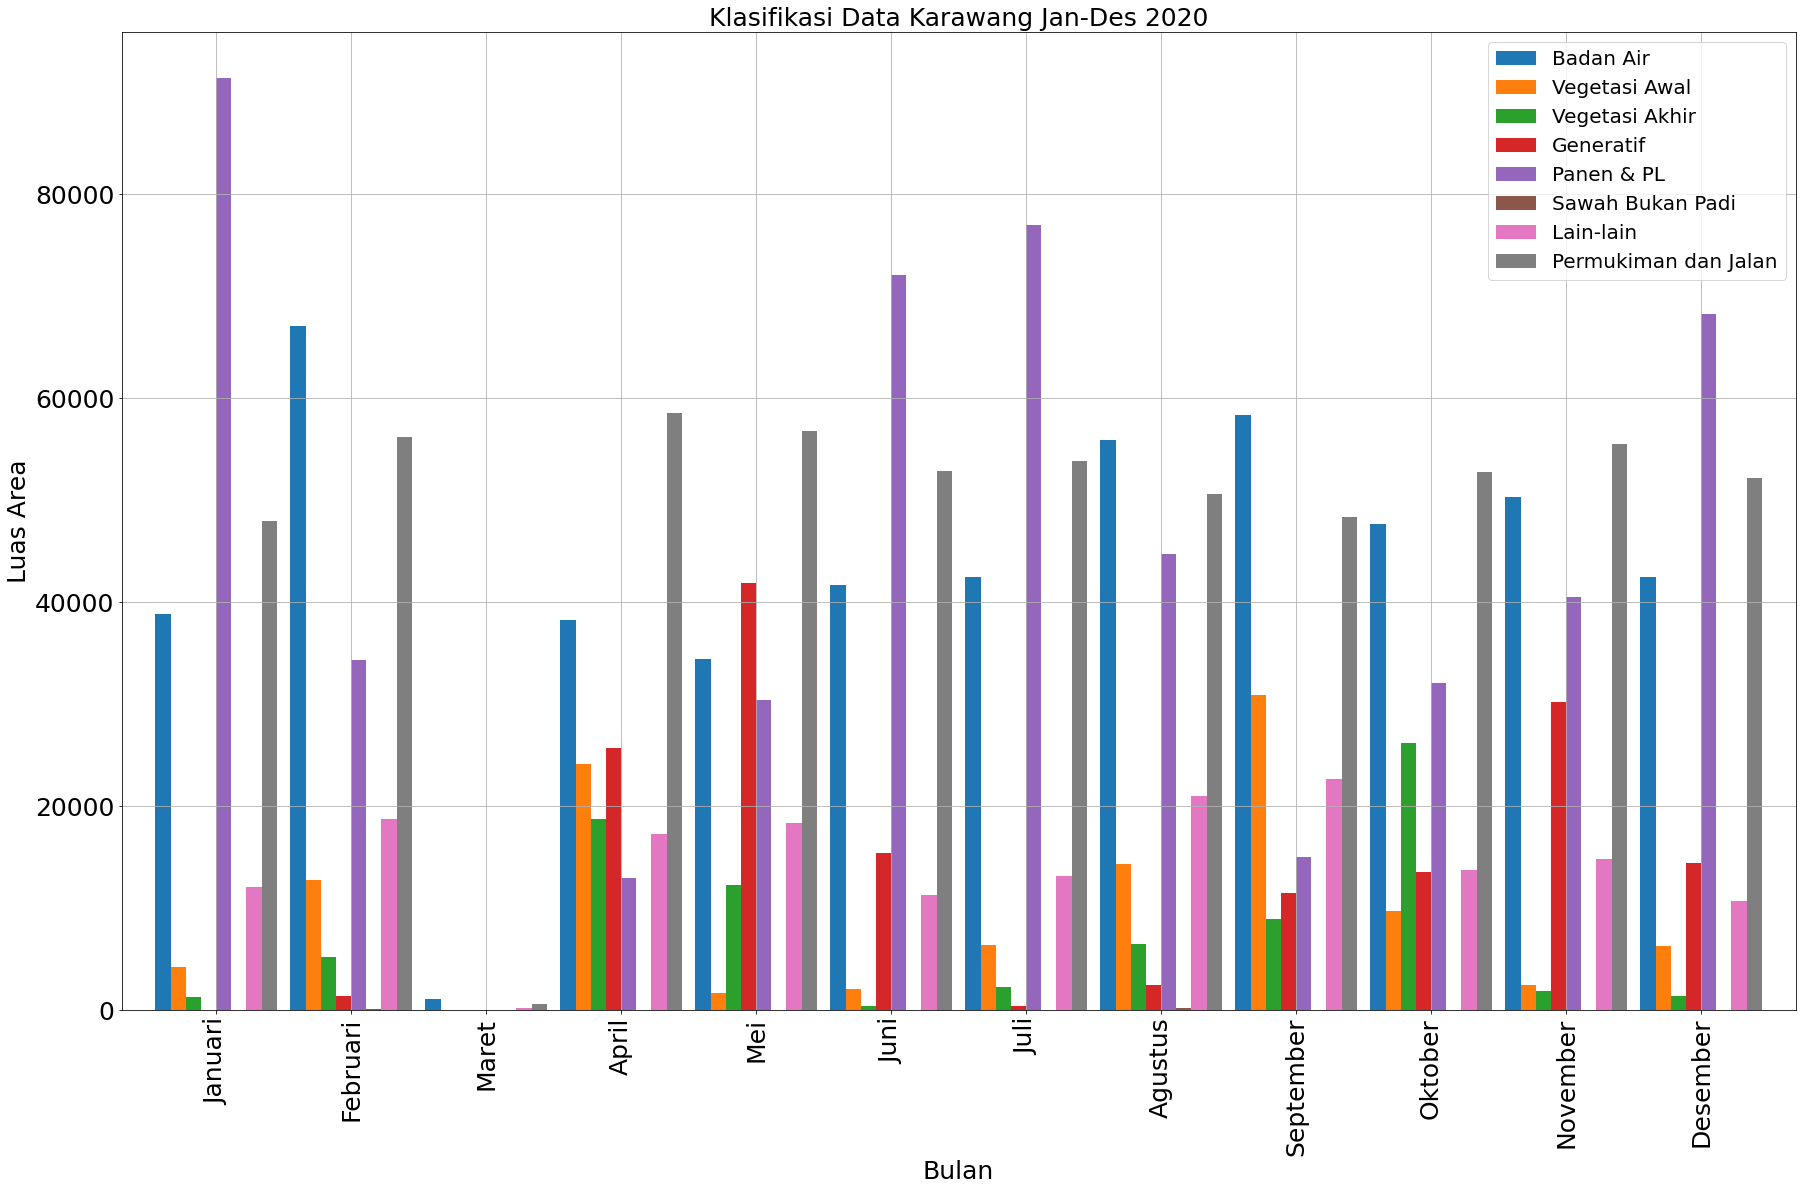

In [77]:
dfgabungan.plot(kind="bar",figsize=(30,18),width=0.9,fontsize=25,legend=True)
plt.title("Klasifikasi Data Karawang Jan-Des 2020", fontsize=25)
plt.xlabel("Bulan", fontsize=25)
plt.ylabel("Luas Area", fontsize =25) #Belum dikali 100
plt.legend(fontsize=20)
plt.grid()

In [78]:
#Membuat dataframe gabungan Jan-Jun
dftotal = pd.DataFrame({'Total': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
dftotal['Bulan'] = ["Januari","Februari", "Maret", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"]
dftotal ['Total'] = [df01.loc[0]['Widearea']+ df01.loc[1]['Widearea']+ df01.loc[2]['Widearea']+ df01.loc[3]['Widearea']+ df01.loc[4]['Widearea']+ df01.loc[5]['Widearea']+ df01.loc[6]['Widearea']+ df01.loc[7]['Widearea'], 
                         df02.loc[0]['Widearea']+ df02.loc[1]['Widearea']+ df02.loc[2]['Widearea']+ df02.loc[3]['Widearea']+ df02.loc[4]['Widearea']+ df02.loc[5]['Widearea']+ df02.loc[6]['Widearea']+ df02.loc[7]['Widearea'],
                         df03.loc[0]['Widearea']+ df03.loc[1]['Widearea']+ df03.loc[2]['Widearea']+ df03.loc[3]['Widearea']+ df03.loc[4]['Widearea']+ df03.loc[5]['Widearea']+ df03.loc[6]['Widearea']+ df03.loc[7]['Widearea'], 
                         df04.loc[0]['Widearea']+ df04.loc[1]['Widearea']+ df04.loc[2]['Widearea']+ df04.loc[3]['Widearea']+ df04.loc[4]['Widearea']+ df04.loc[5]['Widearea']+ df04.loc[6]['Widearea']+ df04.loc[7]['Widearea'], 
                         df05.loc[0]['Widearea']+ df05.loc[1]['Widearea']+ df05.loc[2]['Widearea']+ df05.loc[3]['Widearea']+ df05.loc[4]['Widearea']+ df05.loc[5]['Widearea']+ df05.loc[6]['Widearea']+ df05.loc[7]['Widearea'], 
                         df06.loc[0]['Widearea']+ df06.loc[1]['Widearea']+ df06.loc[2]['Widearea']+ df06.loc[3]['Widearea']+ df06.loc[4]['Widearea']+ df06.loc[5]['Widearea']+ df06.loc[6]['Widearea']+ df06.loc[7]['Widearea'],  
                         df07.loc[0]['Widearea']+ df07.loc[1]['Widearea']+ df07.loc[2]['Widearea']+ df07.loc[3]['Widearea']+ df07.loc[4]['Widearea']+ df07.loc[5]['Widearea']+ df07.loc[6]['Widearea']+ df07.loc[7]['Widearea'],  
                         df08.loc[0]['Widearea']+ df08.loc[1]['Widearea']+ df08.loc[2]['Widearea']+ df08.loc[3]['Widearea']+ df08.loc[4]['Widearea']+ df08.loc[5]['Widearea']+ df08.loc[6]['Widearea']+ df08.loc[7]['Widearea'], 
                         df09.loc[0]['Widearea']+ df09.loc[1]['Widearea']+ df09.loc[2]['Widearea']+ df09.loc[3]['Widearea']+ df09.loc[4]['Widearea']+ df09.loc[5]['Widearea']+ df09.loc[6]['Widearea']+ df09.loc[7]['Widearea'], 
                         df10.loc[0]['Widearea']+ df10.loc[1]['Widearea']+ df10.loc[2]['Widearea']+ df10.loc[3]['Widearea']+ df10.loc[4]['Widearea']+ df10.loc[5]['Widearea']+ df10.loc[6]['Widearea']+ df10.loc[7]['Widearea'], 
                         df11.loc[0]['Widearea']+ df11.loc[1]['Widearea']+ df11.loc[2]['Widearea']+ df11.loc[3]['Widearea']+ df11.loc[4]['Widearea']+ df11.loc[5]['Widearea']+ df11.loc[6]['Widearea']+ df11.loc[7]['Widearea'], 
                         df12.loc[0]['Widearea']+ df12.loc[1]['Widearea']+ df12.loc[2]['Widearea']+ df12.loc[3]['Widearea']+ df12.loc[4]['Widearea']+ df12.loc[5]['Widearea']+ df12.loc[6]['Widearea']+ df12.loc[7]['Widearea']] 
dftotal = dftotal.set_index('Bulan')
dftotal

,Total
Bulan,
Januari,195683.00
Februari,195683.00
Maret,1956.83
April,195683.00
Mei,195683.00
Juni,195683.00
Juli,195683.00
Agustus,195683.00
September,195683.00


## Hitung Rasio Perbedaan 

In [ ]:
# Hitung rasio untuk cek dominasi
def h(bulan,loc):
    #Data count vegetasi awal maret 2020
    if (bulan == 'Januari'):
        df = df01
    if (bulan =='Februari'):
        df = df02
    if (bulan =='Maret'):
        df = df03
    if (bulan =='April'):
        df = df04
    if (bulan =='Mei'):
        df = df05
    if (bulan =='Juni'):
        df = df06
    if (bulan =='Juli'):
        df = df07
    if (bulan =='Agustus'):
        df = df08
    if (bulan =='September'):
        df = df09
    if (bulan =='Oktober'):
        df = df10
    if (bulan =='November'):
        df = df11
    if (bulan =='Desember'):
        df = df12   
    a = df.loc[loc]['Count']
    #Data count total (tanpa badan air dan pemukiman) maret 2020
    counttotal = df.loc[1]['Count'] + df.loc[2]['Count'] + df.loc[3]['Count'] + df.loc[4]['Count'] + df.loc[5]['Count'] + df.loc[6]['Count']
    # Menghitung persentase
    persentase = a/counttotal*100
    return str(np.around(persentase, 2))+'%'
# h('Januari',3)

In [ ]:
#Membuat dataframe gabungan Jan-Jun
dfgabungan1 = pd.DataFrame({'Bulan': pd.Series(dtype='str'),
                   'Vegetasi Awal': pd.Series(dtype='int'),
                   'Vegetasi Akhir': pd.Series(dtype='int'),
                   'Generatif': pd.Series(dtype='int'),
                   'Panen & PL': pd.Series(dtype='int'),
                   'Sawah Bukan Padi': pd.Series(dtype='int'),
                   'Lain-lain': pd.Series(dtype='int'),
                   'Permukiman dan Jalan': pd.Series(dtype='int'),})
#Deklarasi nilai awal dalam dataframe
dfgabungan1['Bulan'] = ["Januari","Februari", "Maret", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"]

dfgabungan1 ['Vegetasi Awal'] = [h('Januari',1), 
                            h('Februari',1),
                            h('Maret',1),
                            h('April',1),
                            h('Mei',1),
                            h('Juni',1),
                            h('Juli',1),
                            h('Agustus',1),
                            h('September',1),
                            h('Oktober',1),
                            h('November',1),
                            h('Desember',1)]
dfgabungan1 ['Vegetasi Akhir'] = [h('Januari',2), 
                            h('Februari',2),
                            h('Maret',2),
                            h('April',2),
                            h('Mei',2),
                            h('Juni',2),
                            h('Juli',2),
                            h('Agustus',2),
                            h('September',2),
                            h('Oktober',2),
                            h('November',2),
                            h('Desember',2)]
dfgabungan1 ['Generatif'] = [h('Januari',3), 
                            h('Februari',3),
                            h('Maret',3),
                            h('April',3),
                            h('Mei',3),
                            h('Juni',3),
                            h('Juli',3),
                            h('Agustus',3),
                            h('September',3),
                            h('Oktober',3),
                            h('November',3),
                            h('Desember',3)]
dfgabungan1 ['Panen & PL'] =[h('Januari',4), 
                            h('Februari',4),
                            h('Maret',4),
                            h('April',4),
                            h('Mei',4),
                            h('Juni',4),
                            h('Juli',4),
                            h('Agustus',4),
                            h('September',4),
                            h('Oktober',4),
                            h('November',4),
                            h('Desember',4)]
dfgabungan1 ['Sawah Bukan Padi'] = [h('Januari',5), 
                            h('Februari',5),
                            h('Maret',5),
                            h('April',5),
                            h('Mei',5),
                            h('Juni',5),
                            h('Juli',5),
                            h('Agustus',5),
                            h('September',5),
                            h('Oktober',5),
                            h('November',5),
                            h('Desember',5)]
dfgabungan1 ['Lain-lain'] = [h('Januari',6), 
                            h('Februari',6),
                            h('Maret',6),
                            h('April',6),
                            h('Mei',6),
                            h('Juni',6),
                            h('Juli',6),
                            h('Agustus',6),
                            h('September',6),
                            h('Oktober',6),
                            h('November',6),
                            h('Desember',6)]
dfgabungan1 ['Permukiman dan Jalan'] = [h('Januari',7), 
                            h('Februari',7),
                            h('Maret',7),
                            h('April',7),
                            h('Mei',7),
                            h('Juni',7),
                            h('Juli',7),
                            h('Agustus',7),
                            h('September',7),
                            h('Oktober',7),
                            h('November',7),
                            h('Desember',7)]

dfgabungan1 = dfgabungan1.set_index('Bulan')
dfgabungan1

#dibandingkan, diliat yg mayoritas itu diatas 50%, dibandingkan dengan data 1 bulan selain pemukiman, badan air

In [ ]:
# cek rasio bukan sebagai str
def n(bulan,loc):
    #Data count vegetasi awal maret 2020
    if (bulan == 'Januari'):
        df = df01
    if (bulan =='Februari'):
        df = df02
    if (bulan =='Maret'):
        df = df03
    if (bulan =='April'):
        df = df04
    if (bulan =='Mei'):
        df = df05
    if (bulan =='Juni'):
        df = df06
    if (bulan =='Juli'):
        df = df07
    if (bulan =='Agustus'):
        df = df08
    if (bulan =='September'):
        df = df09
    if (bulan =='Oktober'):
        df = df10
    if (bulan =='November'):
        df = df11
    if (bulan =='Desember'):
        df = df12   
    a = df.loc[loc]['Count']
    #Data count total (tanpa badan air dan pemukiman) maret 2020
    counttotal = df.loc[1]['Count'] + df.loc[2]['Count'] + df.loc[3]['Count'] + df.loc[4]['Count'] + df.loc[5]['Count'] + df.loc[6]['Count']
    # Menghitung persentase
    persentase = a/counttotal*100
    return np.around(persentase, 2)

#Membuat dataframe gabungan Jan-Jun
dfgabungan2 = dfgabungan = pd.DataFrame({'Bulan': pd.Series(dtype='str'),
                   'Badan Air': pd.Series(dtype='int'),
                   'Vegetasi Awal': pd.Series(dtype='int'),
                   'Vegetasi Akhir': pd.Series(dtype='int'),
                   'Generatif': pd.Series(dtype='int'),
                   'Panen & PL': pd.Series(dtype='int'),
                   'Sawah Bukan Padi': pd.Series(dtype='int'),
                   'Lain-lain': pd.Series(dtype='int'),
                   'Permukiman dan Jalan': pd.Series(dtype='int')})

#Deklarasi nilai awal dalam dataframe
dfgabungan2['Bulan'] = ["Januari","Februari", "Maret", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"]

dfgabungan2 ['Vegetasi Awal'] = [n('Januari',1), 
                            n('Februari',1),
                            n('Maret',1),
                            n('April',1),
                            n('Mei',1),
                            n('Juni',1),
                            n('Juli',1),
                            n('Agustus',1),
                            n('September',1),
                            n('Oktober',1),
                            n('November',1),
                            n('Desember',1)]
dfgabungan2 ['Vegetasi Akhir'] = [n('Januari',2), 
                            n('Februari',2),
                            n('Maret',2),
                            n('April',2),
                            n('Mei',2),
                            n('Juni',2),
                            n('Juli',2),
                            n('Agustus',2),
                            n('September',2),
                            n('Oktober',2),
                            n('November',2),
                            n('Desember',2)]
dfgabungan2 ['Generatif'] = [n('Januari',3), 
                            n('Februari',3),
                            n('Maret',3),
                            n('April',3),
                            n('Mei',3),
                            n('Juni',3),
                            n('Juli',3),
                            n('Agustus',3),
                            n('September',3),
                            n('Oktober',3),
                            n('November',3),
                            n('Desember',3)]
dfgabungan2 ['Panen & PL'] =[n('Januari',4), 
                            n('Februari',4),
                            n('Maret',4),
                            n('April',4),
                            n('Mei',4),
                            n('Juni',4),
                            n('Juli',4),
                            n('Agustus',4),
                            n('September',4),
                            n('Oktober',4),
                            n('November',4),
                            n('Desember',4)]
dfgabungan2 ['Sawah Bukan Padi'] = [n('Januari',5), 
                            n('Februari',5),
                            n('Maret',5),
                            n('April',5),
                            n('Mei',5),
                            n('Juni',5),
                            n('Juli',5),
                            n('Agustus',5),
                            n('September',5),
                            n('Oktober',5),
                            n('November',5),
                            n('Desember',5)]
dfgabungan2 ['Lain-lain'] = [n('Januari',6), 
                            n('Februari',6),
                            n('Maret',6),
                            n('April',6),
                            n('Mei',6),
                            n('Juni',6),
                            n('Juli',6),
                            n('Agustus',6),
                            n('September',6),
                            n('Oktober',6),
                            n('November',6),
                            n('Desember',6)]
dfgabungan2 ['Permukiman dan Jalan'] = [n('Januari',7), 
                            n('Februari',7),
                            n('Maret',7),
                            n('April',7),
                            n('Mei',7),
                            n('Juni',7),
                            n('Juli',7),
                            n('Agustus',7),
                            n('September',7),
                            n('Oktober',7),
                            n('November',7),
                            n('Desember',7)]

In [ ]:
import matplotlib.pyplot as plt
dfgabungan2.plot(kind="bar",figsize=(30,18),width=0.9,fontsize=25,legend=True)
plt.title("Perbandingan Data Karawang Jan-Des 2020", fontsize=25)
plt.xlabel("Bulan", fontsize=25)
plt.ylabel("Luas Area", fontsize =25) #Belum dikali 100
plt.legend(fontsize=20)
plt.grid()

#Perbandingan
# Januari-mei dan september
# februai, juni , oktober
# maret, juli, september dan november

## Comparison Graph 

In [ ]:
!pip install openpyxl

In [ ]:
ksa = pd.read_excel('D:\Kuliah\KP\#paper\hasil_ksa_2020.xlsx')
# print(dataframe1)

In [ ]:
def showPlotBanding(n, label):
    x_ar = [ksa[n][1], ksa[n][2], ksa[n][4],ksa[n][5],ksa[n][6],ksa[n][7],ksa[n][8],ksa[n][9],ksa[n][10],ksa[n][11],ksa[n][12]]
    y_ar = [df01.loc[n]['Widearea'], 
               df02.loc[n]['Widearea'], 
               df04.loc[n]['Widearea'], 
               df05.loc[n]['Widearea'], 
               df06.loc[n]['Widearea'],
               df07.loc[n]['Widearea'], 
               df08.loc[n]['Widearea'], 
               df09.loc[n]['Widearea'], 
               df10.loc[n]['Widearea'], 
               df11.loc[n]['Widearea'], 
               df12.loc[n]['Widearea']]
    x_arr = np.array(x_ar)
    y_arr = np.array(y_ar)
    forPlot = pd.DataFrame({
       str(label)+' KSA': x_arr,
       str(label)+' GB': y_arr}, index=["Januari","Februari", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"])

    lines = forPlot.plot.line()
#     index=["Januari","Februari", "April", "Mei", "Juni","Juli","Agustus","September","Oktober","November","Desember"]
#     for x,y in zip(index,y_arr):

#         label1 = "{:.2f}".format(y)

#         plt.annotate(label1, # this is the text
#                      (x,y), # this is the point to label
#                      textcoords="offset points", # how to position the text
#                      xytext=(0,10), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be
#     for x,y in zip(index,x_arr):    
#         labelk = "{:.2f}".format(x)
#         plt.annotate(labelk, # this is the text
#                      (x,x), # this is the point to label
#                      textcoords="offset points", # how to position the text
#                      xytext=(0,10), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be
    return lines

In [ ]:
# Vegetasi Awal
showPlotBanding(1,'V1')

In [ ]:
# Vegetasi Akhri
showPlotBanding(2,'V2')

In [ ]:
# Generatif
showPlotBanding(3,'G')

In [ ]:
# P&PL
showPlotBanding(4,'P& PL')

In [ ]:
# Sawah bukan padi
# ga masuk paper kayaknya
showPlotBanding(5,'Sawah bukan padi')

In [ ]:
x1 = [0,1,4,5,7,0,1,0,6,2]
y1 = [1,2,3,4,4,1,4,3,1,0]
x2= np.array(x1)
y2 = np.array(y1)
# plt.plot(x_arr, y_arr)
f = pd.DataFrame({
       ' KSA': x2,
       ' GB': y2})
lines = f.plot.line()
# zip joins x and y coordinates in pairs
for x,y in zip(x2,y2):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be
    labelk = "{:.2f}".format(x)

    plt.annotate(labelk, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be